In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# i went to the ____ and then washed my ____
# i went to the bank and then washed my hair
# i went to the store and then washed my cat

# SourceDoc

In [3]:
from src.sourcedoc import SourceTM

course_name = 'hmds'
data_dir = 'data/tm_wiki/{}'.format(course_name)
graph_path = 'data/tm_wiki/{}/wikigraph.pkl'.format(course_name)

# from src.wikigraph import WikiGraph, make_wikigraph, compile_wikigraph_edges
# from run_make_wikicorpus import clean_rib, clean_hmds

# clean_fn = clean_hmds
# corpus = SourceTM(data_dir)
# wikigraph = make_wikigraph(corpus, clean_fn=clean_hmds)
# wikigraph = compile_wikigraph_edges(wikigraph)
# wikigraph.save(graph_path)

<AxesSubplot:>

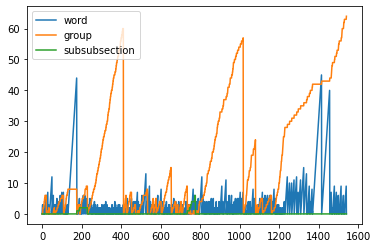

In [4]:
SourceTM(data_dir=data_dir).df[['word', 'group', 'subsubsection']].plot()

In [5]:
from src.sourcedoc import SourceTM, SourceDIF         
from src.fuzzy import FuzzyModels

In [6]:
srcs = {
    'hmds_tm':SourceTM(data_dir='data/tm_wiki/hmds'),
    'rib_tm':SourceTM(data_dir='data/tm_wiki/rib'),
    'hmds_dif':SourceDIF(data_dir='data/dif/hmds'),
    'rib_dif':SourceDIF(data_dir='data/dif/rib'),
}

fuzzymodels = FuzzyModels(
    model_name='bert-base-uncased', 
    path_dict = {
        'base':'bert-base-uncased',
        'hmds':'./outputs/lm_hmds-wiki_bert-uncased/pytorch_model.bin',
        'rib':'./outputs/lm_rib-wiki_bert-uncased/pytorch_model.bin'
    }
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
srcs['hmds_tm'].df.head()
srcs['hmds_tm'].src.head()

,word,group,subsubsection,subsection,section,content
0,0,0,0,0,0,Vehicle
1,1,0,0,0,0,Modular
2,2,0,0,0,0,Decontamination
3,3,0,0,0,0,System
4,0,1,0,0,0,(VMDS)


,subsubsection,subsection,section,content
0,0,0,0,Vehicle Modular Decontamination System
1,0,0,0,(VMDS)
2,0,0,0,“Version B” Prototype System
3,0,0,0,OPERATOR'S MANUAL
4,0,0,0,ELIN A004


In [8]:
import numpy as np
import pandas as pd
import torch

def get_top_scores(query, vocab, embeddings, thresh, topk):
    scores = (embeddings@query)/(np.linalg.norm(embeddings, axis=-1)*np.linalg.norm(query))
    return [(vocab[i], scores[i]) for i in scores.argsort()[-topk:][::-1] if scores[i]>thresh]

def query_search(query, fuzzymodels, model, src, thresh=0.75, topk=10):
    vocab = list(src.uniq_words)
    embeddings = src.embeddings[model]
    results = {}

    for q in query.split():
        qq = fuzzymodels._embed(fuzzymodels.models[model], q).detach().numpy()
        results[q] = [
            (x[1], x[0]) 
            for x in get_top_scores(qq, vocab, embeddings, thresh=thresh, topk=topk)
        ]
    return results

def query_search2(query, fuzzymodels, model, tokenizer, src, thresh=0.75, topk=10):
    vocab = list(src.uniq_words)
    embeddings = src.embeddings[model]
    results = {}

    for q in query.split():
        data = {k:torch.LongTensor(v).unsqueeze(0) for k,v in tokenizer(q).items()} 
        qq = fuzzymodels._embed2(fuzzymodels.models[model], data).detach().numpy()
        results[q] = [
            (x[1], x[0]) 
            for x in get_top_scores(qq, vocab, embeddings, thresh=thresh, topk=topk)
        ]

    return results


def query_search3(tokenized_data, fuzzymodels, model, src, thresh=0.75, topk=10):
    vocab = list(src.uniq_words)
    embeddings = src.embeddings[model]
    results = {}

    for q,data in tokenized_data.items():
        qq = fuzzymodels._embed2(fuzzymodels.models[model], data).detach().numpy()
        results[q] = [
            (x[1], x[0]) 
            for x in get_top_scores(qq, vocab, embeddings, thresh=thresh, topk=topk)
        ]

    return results

def format_results(results):
    formatted = {}
    
    for k,v in results.items():
        formatted[k] = ['{:.3f} {}'.format(x[0], x[1]) for x in v]
    return formatted

def _word_scores(results):
    word_scores = {}
    
    for k,v in results.items():
        for score, word in v:
            if word in word_scores:
                word_scores[word] +=score
            else:
                word_scores[word] = score
    return word_scores

def _get_idxs_scores(word_scores, src, shape=None):
    all_idxs, all_scores = [], []
    for k,v in word_scores.items():
        idxs = np.array([src.idx_map[idx] for idx in src.uniq_words[k]]).T
        all_idxs.append(idxs)
        all_scores.append(np.array([v]*idxs.shape[-1]))
        
    all_idxs, all_scores = np.concatenate(all_idxs, axis=-1), np.concatenate(all_scores, axis=-1)
    return all_idxs, all_scores

def _sparse_scores(word_scores, src, shape=None):
    all_idxs, all_scores = _get_idxs_scores(word_scores, src, shape=None)
    if shape is None:
        shape = tuple(x.max()+1 for x in all_idxs)
    return torch.sparse_coo_tensor(all_idxs, all_scores, shape)

def compute_sparse_score(src, results):
    ws = {k:_word_scores({k:v}) for k,v in results.items()}
    
    all_idxs = []
    for k,v in ws.items():
        _idx, _ = _get_idxs_scores(v, src)
        all_idxs.append(_idx)
    all_idxs = np.concatenate(all_idxs, axis=-1)
    shape = tuple(x.max()+1 for x in all_idxs)
    ss1 = {k:_sparse_scores(v, src, shape=shape) for k,v in ws.items()}
    ss2 = {k:torch.sparse.sum(v, dim=-1) for k,v in ss1.items()}
    ss3 = {k:torch.sparse.sum(v, dim=-1) for k,v in ss2.items()}
    
    scores = [x*(1/torch.max(x.values())) for x in ss3.values()]
    return torch.sparse.sum(torch.stack(scores), dim=0)

def ranked_indices(src, results):
    cols = ['tlo', 'elo', 'page', 'score']
    outcols = ['page', 'elo', 'tlo', 'score']
    if len(results)==0:
        return pd.DataFrame(columns=outcols)

    sparse_scores = compute_sparse_score(src, results)
    indices = pd.DataFrame(torch.cat([
        sparse_scores.indices().T, 
        sparse_scores.values().unsqueeze(0).T
    ], dim=-1).numpy(), columns=cols)
    
    for col in cols[:-1]:
        indices[col] = indices[col].astype(np.int64)
    indices = indices.sort_values(by='score', ascending=False)
    return indices[outcols]

In [13]:
import re
from src.utils import uniq

class Highlight:
    def __init__(self, keywords):
        self.keywords = keywords+[k.title() for k in keywords]
        self.rep = self._make_rep()
        self.pattern = self._make_pattern()
        
    def _make_rep(self):
        return dict(sorted(zip(
            list(map(re.escape, self.keywords)), 
            list(map(lambda x: '**{}**'.format(x), self.keywords))
        ), key=lambda x: len(x[0]), reverse=True))
    
    def _make_pattern(self):
        return re.compile("|".join(self.rep.keys()))
    
    def __call__(self, text):
        if len(self.rep)>0:
            return self.pattern.sub(lambda x: self.rep[re.escape(x.group(0))], text)
        else:
            return text

def get_lines(df, page, elo, tlo):
    return df[(df.page==page)&(df.elo==elo)&(df.tlo==tlo)]

def get_lil_results(src, rankings, highlight):
    lil_results = []
    
    for i,row in rankings.iterrows():
        lil_results.append([])
        page, elo, tlo = int(row.page), int(row.elo), int(row.tlo)
        lines = get_lines(src.df, page, elo, tlo)
        
        for x in lines.groupby('line'):
            lil_results[-1].append(highlight(' '.join(x[1].content)))
            
        if len(lil_results[-1][0])>200:
            text = lil_results.pop(-1)
            text = text[0].split()[:3]+text
            lil_results.append(text)

        lil_results[-1][0] = '{}-{}-{} {} ({:.2f})'.format(tlo, elo, page, lil_results[-1][0].replace('*',''), row.score)
    return lil_results

def get_by_page(src, highlight):
    lil_results = []
    
    for page, elo, tlo in uniq(src.df[['page', 'elo', 'tlo']].to_records(index=False).tolist()):
        lil_results.append([])
        lines = get_lines(src.df, page, elo, tlo)
        
        for x in lines.groupby('line'):
            lil_results[-1].append(highlight(' '.join(x[1].content)))
            
        if len(lil_results[-1][0])>200:
            lil_results[-2]+=lil_results.pop(-1)
        else:
            lil_results[-1][0] = '{}-{}-{} {}'.format(tlo, elo, page, lil_results[-1][0])
    return lil_results

def get_by_page2(df, highlight, idxs_cols=['page', 'elo', 'tlo']):
    lil_results = []
    
    for page, elo, tlo in uniq(df[idxs_cols].to_records(index=False).tolist()):
        lil_results.append([])
        lines = get_lines(df, page, elo, tlo)
        
        for x in lines.groupby('line'):
            lil_results[-1].append(highlight(' '.join(x[1].content)))
            
        if len(lil_results[-1][0])>200:
            lil_results[-2]+=lil_results.pop(-1)
        else:
            lil_results[-1][0] = '{}-{}-{} {}'.format(tlo, elo, page, lil_results[-1][0])
    return lil_results

In [14]:
results = query_search('broken tank', fuzzymodels, 'hmds', srcs['hmds_dif'], thresh=0.83)

In [15]:
results

{'broken': [(0.9999999, 'broken'),
  (0.86243474, 'breaking'),
  (0.83637905, 'break')],
 'tank': [(1.0, 'tank'),
  (0.89986354, 'tanks'),
  (0.8405048, 'tank pump'),
  (0.8357764, 'tank once'),
  (0.83279747, 'two tank')]}

In [16]:
sparse_scores = compute_sparse_score(srcs['hmds_dif'], results)
sparse_scores

tensor(indices=tensor([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                         2,  2,  2,  2,  2,  4,  4,  4,  4,  4,  4,  4,  4,  4,
                         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
                         5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  7,
                         7,  7,  7,  7,  7,  7,  7,  7,  7],
                       [ 5,  6,  6,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
                        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 16, 18, 19, 19,
                         3,  4,  4,  7,  9,  2,  5,  6,  6,  7,  7,  8,  8,  9,
                         9, 10, 11, 12, 13, 14, 15, 16, 16, 17, 24, 25, 25,  3,
                         6,  6,  6,  6,  7,  9,  9,  4,  4,  6,  7, 11, 11, 11,
                        11, 11, 11, 11, 11, 11, 11, 11, 11],
                       [ 1,  1,  2,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  1

In [17]:
results = query_search('broken tank', fuzzymodels, 'hmds', srcs['hmds_dif'], thresh=0.83)
rankings = ranked_indices(srcs['hmds_dif'], results)
highlight = Highlight([x[1] for y in results.values() for x in y])
get_lil_results(srcs['hmds_dif'], rankings, highlight)

[['1-9-5 Tank Hopper/Blender (1.15)',
  'The stainless steel Hopper/Blender is used to aid in mixing powdered, liquid, and granular decontaminant materials into a **tank**. It has a 16" diameter and the funnel section is 22" deep. It has a plastic lid, which is attached by a lanyard, and a removable stainless steel screen. The screen has a handle on top and several 1" diameter holes across its surface. The holes assist with **breaking** up clumps of powdered or granular decontaminant that could clog the 1.5" diameter funnel output spout. The Hopper/Blender is primarily fed by a 1.5" EZLink camlock fitting on the White Banded Hopper Hose. Alternatively, it can be fed by the Red Banded Discharge Hoses, or any other 1.5" diameter hose in the HMDS hose kit. The Hopper/Blender is located next to the Agitator and has two (2) 1/2" stainless steel bars in the funnel section. These bars support the removable screen and help prevent objects from accidentally falling into the **tank**. If there a

In [18]:
results

{'broken': [(0.9999999, 'broken'),
  (0.86243474, 'breaking'),
  (0.83637905, 'break')],
 'tank': [(1.0, 'tank'),
  (0.89986354, 'tanks'),
  (0.8405048, 'tank pump'),
  (0.8357764, 'tank once'),
  (0.83279747, 'two tank')]}

In [19]:
rankings

,page,elo,tlo,score
8,5,9,1,1.153591
57,1,6,5,1.000000
47,1,14,4,0.716758
51,1,17,4,0.665561
64,1,4,6,0.609237
...,...,...,...,...
23,10,11,1,0.046070
33,1,2,4,0.046070
37,0,7,4,0.046070
41,0,9,4,0.046070


In [20]:
get_by_page(srcs['hmds_dif'], highlight)

[['0-0-0 High Mobility Decontamination System'],
 ['0-1-0 CBRN PROTECTION',
  'High Mobility Decontamination System (HMDS)',
  'The following course has been optimized to run in Microsoft Edge',
  'DISTRIBUTION STATEMENT F: Further dissemination only as directed by Joint Project Manager for Chemical, Biological, Radiological, and Nuclear Protection (23 February 2021) or higher DoD authority.'],
 ['0-2-0 How to use this course'],
 ['0-2-1 Course Navigation',
  'HIGH MOBILITY DECONTAMINATION SYSTEM',
  'Course title and page name. Current page location in course. Left click the next or previous arrow to navigate to that page (when available).',
  'Course Navigation',
  'DISTRIBUTION STATEMENT F: Further dissemination only as directed by Joint Project Manager for Chemical, Biological, Radiological, and Nuclear Protection (23 February 2021) or higher DoD authority.'],
 ['0-2-2 Video',
  'HIGH MOBILITY DECONTAMINATION SYSTEM',
  'Click on any step to advance to that section in the video. Cl

In [21]:
get_lil_results(srcs['hmds_dif'], rankings, highlight)

[['1-9-5 Tank Hopper/Blender (1.15)',
  'The stainless steel Hopper/Blender is used to aid in mixing powdered, liquid, and granular decontaminant materials into a **tank**. It has a 16" diameter and the funnel section is 22" deep. It has a plastic lid, which is attached by a lanyard, and a removable stainless steel screen. The screen has a handle on top and several 1" diameter holes across its surface. The holes assist with **breaking** up clumps of powdered or granular decontaminant that could clog the 1.5" diameter funnel output spout. The Hopper/Blender is primarily fed by a 1.5" EZLink camlock fitting on the White Banded Hopper Hose. Alternatively, it can be fed by the Red Banded Discharge Hoses, or any other 1.5" diameter hose in the HMDS hose kit. The Hopper/Blender is located next to the Agitator and has two (2) 1/2" stainless steel bars in the funnel section. These bars support the removable screen and help prevent objects from accidentally falling into the **tank**. If there a

In [54]:
print_lines(srcs['hmds_dif'].df[
    (srcs['hmds_dif'].df.page==1)&
    (srcs['hmds_dif'].df.elo==6)&
    (srcs['hmds_dif'].df.tlo==5)
], keywords)

['Configuration of the Tanks and Hoses',
 'HIGH MOBILITY DECONTAMINATION SYSTEM',
 'The primary slurry mixing configuration is conducted by a Power Unit and main **tank** with a secondary **tank** filled with rinse/source water. Two Tanks (Truck and Trailer) The Two-Tank configuration uses both of the 750-Gallon **tanks** for the slurry mixing operation. The main (truck) **tank** is used to mix the slurry and the trailer **tank** is a source of water for mixing and rinsing the truck **tank**. The availability of rinse water is necessary to help clear any clogged lines and to rapidly flush out the system after discharging the slurry. Using the Tank Selector Valve attached to the rear of the Power Unit, attach the Suction Main (Single Black Band) hose to the left side of the Tank Selector Valve and the Trailer Suction hose (Double Black Band) to the right side. Then, connect each hose to the appropriate **tank** and open up the Tank Drain Valves. Connect the White Banded Hopper/Blender h

In [61]:
print_lines(srcs['hmds_dif'].df[
    (srcs['hmds_dif'].df.page==1)&
    (srcs['hmds_dif'].df.elo==14)&
    (srcs['hmds_dif'].df.tlo==4)
])

['Tank-to-Tank Operation',
 'HIGH MOBILITY DECONTAMINATION SYSTEM',
 'Using the HMDS, water can be transferred from one "holding" tank to another "recipient" tank. This is called a Tank-to-Tank Operation. In the example below, water will be drawn from the "holding" trailer tank to fill the "recipient" truck tank. Turn the Air Control valve and Pump Control valve to the full OFF position.Ensure that the trailer tank is filled with water.Use the White Banded hose to connect the Hopper/Blender on the truck tank to the Discharge Line #2 port on the front of the Power Unit. Alternatively, use the Purple Banded hose to connect the Hopper/Blender on the truck tank to the Monitor output port on the back of the Power Unit.Attach the Tank Selector valve to the Fluid Input port on the back of the Power Unit.Use the short Black Banded hose to connect the Fluid In/Drain valve on the truck tank to the short connector on the Tank Selector valve.Use the long, Double Black Banded hose to connect the Fl

In [62]:
print_lines(srcs['hmds_dif'].df[
    (srcs['hmds_dif'].df.page==1)&
    (srcs['hmds_dif'].df.elo==17)&
    (srcs['hmds_dif'].df.tlo==4)
])

['Attach Selected Hose to Hopper/Blender Port on Main Tank',
 'Turn Tank Selector Valve Handle to Draw Water from Trailer',
 'Attach Yellow Banded Hose to Agitator Output Port',
 'Open the Tank Drain Valve',
 'Attach Double Red or Purple Banded Hose to Monitor Output',
 'Introduction',
 'Attach Double Black Banded Hose to Tank Drain on Trailer Tank',
 'Mixing with a Single Tank',
 'Attach Yellow Banded Hose to Agitator Port on Main Tank',
 'HIGH MOBILITY DECONTAMINATION SYSTEM',
 'Attach Black Banded Hose to Left Side of the Tank Selector Valve',
 'Steps 2 of 2',
 'Dump Decontaminant into the Hopper/Blender on Main Tank',
 'Attach Black Banded Hose to Tank Drain Valve on Main Tank',
 'Steps 1 of 2',
 'Turn on the Power Unit',
 'Attach Double Black Banded Hose to Right Side Tank Selector',
 'Attaching the Mixing Hoses and Mixing a Solution',
 'Set Selector Valve 1 to Agitator and Selector Valve 2 to Monitor',
 'Attach the Tank Selector Valve to the Fluid Input Port',
 'Turn on the Pump 

# DIF

In [48]:
testy = SourceDIF(data_dir='data/dif/hmds')

In [50]:
testy.uniq_words.keys()

dict_keys(['', '1', '1 000', '1 2', '1 4', '1 5', '1 800 468 6090', '10', '10 000', '10 15', '100', '11', '115', '12', "12'", '12v', '13', '14', '15', '15 30', "15'", '16', "16'", "17'", '18', '1off', '2', '2 in 1', "2'", "2's", '20', "20'", '2021', '22', '22556', '23', '24', '24 28', "25'", '2off', '3', '3 333', '3 4', '3 8', '3 81cm', '30', '301stafford', '303 309 6309www intelagard come mail', '318', '32', "32'", '34', "35'", '36', '360 degree', '3d', '4', '4 way', "4'", '40', '43 5', '45', '5', '5 gallon', '50', "50'", '550', '6', "6'", '60', "60'", '68', '7', '7 500', '72', '732', '750', '750 gallon', '757 8252e mail', '78', '8', "8'", '80', '80 degree', '80020', '9', '90 95', "90'", '92', '98', 'a', 'ability', 'able', 'above', 'access', 'accessories', 'accessory', 'accidental', 'accidentally', 'accommodate', 'accordance', 'according', 'accordingly', 'acronym', 'across', 'act', 'action', 'actions', 'actionsadd', 'actionscheck', 'actionsclean', 'actionscontact', 'actionsflush', 'ac

In [38]:
difpaths = sorted(glob.glob(/*'))

In [40]:
source = pd.read_csv(difpaths[0]).dropna()

,content
0,HIGH
1,MOBILITY
2,DECONTAMINATION
3,SYSTEM
4,General
...,...
23774,2021)
23775,or
23776,higher
23777,DoD


In [30]:
pd.read_csv(difpaths[1])

,PageID,TextDisplayValue
0,59944,HIGH MOBILITY DECONTAMINATION SYSTEM
1,59949,General Safety Warnings
2,59942,HIGH MOBILITY DECONTAMINATION SYSTEM
3,59952,HIGH MOBILITY DECONTAMINATION SYSTEM
4,59940,CBRN PROTECTION
...,...,...
1403,60271,DISTRIBUTION STATEMENT F: Further disseminat...
1404,60409,DISTRIBUTION STATEMENT F: Further disseminat...
1405,60457,DISTRIBUTION STATEMENT F: Further disseminat...
1406,60242,DISTRIBUTION STATEMENT F: Further disseminat...


# WikiCorpus

In [114]:
import torch

In [5]:
from src.wikigraph import WikiGraph

wikigraph = WikiGraph(data_dir=data_dir)
wikigraph.load(graph_path)

In [8]:
sorted(wikigraph.nodes)

['/wiki/AMC_Ambassador',
 '/wiki/AMD_Accelerated_Processing_Unit',
 '/wiki/APL_syntax_and_symbols',
 '/wiki/A_Cure_for_Wellness',
 '/wiki/A_Streetcar_Named_Desire',
 '/wiki/Abrasive_blasting',
 '/wiki/Acanthurus_olivaceus',
 '/wiki/Access_control',
 '/wiki/Access_network',
 '/wiki/Accident',
 '/wiki/Achtung_Baby',
 '/wiki/Action_item',
 '/wiki/Active_fire_protection',
 '/wiki/Active_transport',
 '/wiki/Actuator',
 '/wiki/Adapted_automobile',
 '/wiki/Adaptive_reuse',
 '/wiki/Additional_Mathematics',
 '/wiki/Additional_member_system',
 '/wiki/Additional_secretary_to_the_Government_of_India',
 '/wiki/Adjustable_gastric_band',
 '/wiki/Advanced_Placement',
 '/wiki/Aerial_work_platform',
 '/wiki/Aerospike_engine',
 '/wiki/Agent_Orange',
 '/wiki/Agitated_Nutsche_Filter',
 '/wiki/Agitation_Free',
 '/wiki/Ahmedabad',
 '/wiki/Aileen_Lee',
 '/wiki/AirPort_Express',
 '/wiki/Air_compressor',
 '/wiki/Air_conditioning',
 '/wiki/Air_filter',
 '/wiki/Air_flow_bench',
 '/wiki/Air_gun',
 '/wiki/Air_pollu